**Import Libraries**

In [1]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import speech_recognition as sr

**Select Model**

In [2]:
class AudioStressCNN(nn.Module):
    def __init__(self, num_classes=7):  # Number of output classes
        super(AudioStressCNN, self).__init__()
        
        # 1D CNN Layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(256)
        
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Dropout layer for CNN feature extraction
        self.dropout_cnn = nn.Dropout(0.2)

        # LSTM Layer for capturing temporal dependencies
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(128 * 2, 256)  # Bidirectional LSTM doubles the hidden size
        self.dropout_fc = nn.Dropout(0.5)  # Dropout after FC1
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_cnn(x)

        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_cnn(x)

        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout_cnn(x)

        # Transpose for LSTM
        x = x.permute(0, 2, 1)

        # LSTM for temporal modeling
        x, _ = self.lstm(x)

        # Take the last time step's output
        x = x[:, -1, :]

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Load the complete model
model = torch.load("models/trained_model_modify_cnn_lstm_audio.pth")
# Define the model architecture (must match the one used during training)
model = AudioStressCNN()

# Load the state dictionary
model.load_state_dict(torch.load("models/trained_model_modify_cnn_lstm_audio.pth", map_location=torch.device("cpu")))




# # Define the path to the saved model
# model_path = "models/trained_model_modify_cnn_lstm_audio.pth"

# model=AudioStressCNN()
# # Load the model's state_dict (weights)
# model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
# model.eval()  # Set the model to evaluation mode

<All keys matched successfully>

**Transcribe Module**

In [4]:
# Function to transcribe the audio to text
def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)
    
    with audio as source:
        audio_data = recognizer.record(source)
        
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        text = "Unable to transcribe"
    except sr.RequestError as e:
        text = f"Error: {e}"
    
    return text

**Level Detection Module**

In [5]:
# # Function to predict stress level from an audio file
# def predict_stress_from_file(audio_path):
#     try:
#         # Load audio file
#         audio_data, sr = librosa.load(audio_path, sr=16000)  # Resample to 16 kHz
#         print(f"Audio file loaded: {audio_path}, Duration: {len(audio_data)/sr:.2f} seconds")

#         # Extract MFCC features
#         mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=40)
#         mfcc = np.mean(mfcc.T, axis=0)
#         mfcc = np.expand_dims(mfcc, axis=(0, 1))  # Add batch and channel dimensions

#         # Convert to tensor
#         mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)

#         # Predict using the model
#         output = model(mfcc_tensor)
#         _, predicted = torch.max(output, 1)

#         # Map prediction to stress level
#         label_mapping = {0: '1 (Low)', 1: '2 (Low-Mild)', 2: '4 (Mild)', 3: '5 (Moderate)', 4: '6 (Moderate-High)', 5: '8 (high)', 6: '9 (critical)'}

#         stress_level = label_mapping[predicted.item()]
#         return stress_level
#     except Exception as e:
#         print(f"Error processing file: {e}")
#         return "Error"
    
    
# Function to predict stress level
def predict_stress_from_file(audio_path):
    try:
        # Load audio file
        audio_data, sr = librosa.load(audio_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=40)
        mfcc = np.mean(mfcc.T, axis=0)
        mfcc = np.expand_dims(mfcc, axis=(0, 1))  # Add batch and channel dimensions

        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        output = model(mfcc_tensor)
        _, predicted = torch.max(output, 1)

        # Map prediction to stress level
        label_mapping = {
            0: "1 (low)",  # Low stress
            1: "2 (low-mild)",
            2: "4 (mild)",
            3: "5 (mild-moderate)",
            4: "6 (modetate-high)",
            5: "8 (high-critical)",
            6: "9 (critical)",  # Critical
        }
        return label_mapping[predicted.item()]
    except Exception as e:
        st.error(f"Error processing file: {e}")
        return 0

**Inference**

In [44]:
# Input from the user
audio_file_path = "dataset/test_data/fire.wav"
text=transcribe_audio(audio_file_path)
print(f"Audio Text: {text}")
# Predict stress level
predicted_stress_level = predict_stress_from_file(audio_file_path)
print(f"Predicted Stress Level: {predicted_stress_level}")


# Visualize the Level
import matplotlib.pyplot as plt
import numpy as np
# Define the label mapping
label_mapping = {
    0: "1 (low)",  # Low stress
    1: "2 (low-mild)",
    2: "4 (mild)",
    3: "5 (mild-moderate)",
    4: "6 (moderate-high)",
    5: "8 (high-critical)",
    6: "9 (critical)",  # Critical
}

# Reverse mapping for visualization indices
level_indices = {v: k for k, v in label_mapping.items()}

def visualize_stress_level_circular(level_label, max_level=7):
    # Get the numeric index of the stress level
    if level_label not in level_indices:
        raise ValueError(f"Invalid stress level label: {level_label}")
    
    level_index = level_indices[level_label] + 1  # Convert to 1-based index
    levels = list(label_mapping.values())  # List of all levels

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Define the angles for each level
    theta = np.linspace(0, 2 * np.pi, max_level, endpoint=False)
    radii = [1] * max_level
    colors = ['silver'] * max_level
    colors[level_index - 1] = 'red'  # Highlight the predicted level

    # Create bars for each level
    bars = ax.bar(theta, radii, color=colors, width=2 * np.pi / max_level, edgecolor='black', align='edge')

    # Add a needle pointing to the predicted level
    needle_angle = theta[level_index - 1]
    ax.plot([0, needle_angle], [0, 1.0], color='red', linewidth=1, label=f"Predicted Level: {level_label}")

    # Add labels
    ax.set_yticks([])
    ax.set_xticks(theta)
    ax.set_xticklabels(levels)
    ax.legend(loc="upper right")
    #ax.set_title("Stress Level Visualization (Dial)")
    plt.show()

# Example usage
stress_level = predicted_stress_level  # Replace this with your prediction
#visualize_stress_level_circular(stress_level)


Audio Text: places on Fire please send help
Predicted Stress Level: 8 (high-critical)


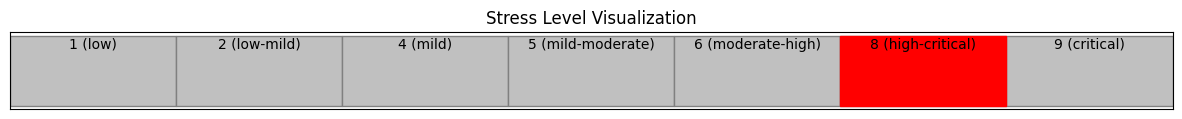

In [32]:
def visualize_stress_level_slider(level_label, max_level=7):
    # Get the numeric index of the stress level
    if level_label not in level_indices:
        raise ValueError(f"Invalid stress level label: {level_label}")
    
    level_index = level_indices[level_label] + 1  # Convert to 1-based index
    levels = list(label_mapping.values())  # List of all levels

    fig, ax = plt.subplots(figsize=(15, 1))

    # Create a horizontal bar for the slider
    slider_width = 1.0 / max_level
    for i in range(max_level):
        ax.barh(0, slider_width, left=i / max_level, color='silver', edgecolor='gray')
    ax.barh(0, slider_width, left=(level_index - 1) / max_level, color='red', edgecolor='red')

    # Add level labels
    for i, label in enumerate(levels):
        ax.text(i / max_level + slider_width / 2, 0.3, label, ha='center', va='center', fontsize=10)

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("Stress Level Visualization")

    plt.show()

# Example usage
stress_level = predicted_stress_level  # Replace this with your prediction
visualize_stress_level_slider(stress_level)